In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
origin_data = pd.read_csv("lending_club_2020_train.csv")
origin_data.head()

/var/folders/6h/grchm_d95kq59vq4y3tnsm7c0000gn/T/ipykernel_1625/2075965412.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  origin_data = pd.read_csv("lending_club_2020_train.csv")


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,124989905,6000.0,6000.0,6000.0,36 months,7.97%,187.94,A,A5,Teacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,139665484,35000.0,35000.0,35000.0,60 months,14.47%,822.95,C,C2,Product Specialist,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,84253847,23200.0,23200.0,23200.0,60 months,24.99%,680.82,E,E4,Production Foreman,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
3,126296074,4500.0,4500.0,4500.0,36 months,9.93%,145.06,B,B2,Office Manager,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,148913312,15000.0,15000.0,15000.0,36 months,16.40%,530.33,C,C4,Secretary,...,May-2020,Jul-2020,May-2020,2.0,0.0,ACTIVE,413.83,11025.25,54.62,N


In [5]:
# drop할 컬럼들을 일단 처리한다.
with open('drop_columns.txt', mode='r') as f:
    drop_fields = f.readlines()
    drop_fields = [drop_field.strip('\n') for drop_field in drop_fields]

In [6]:
drop_df = origin_data.drop(columns=drop_fields)

In [7]:
len(drop_df.columns)

96

In [8]:
drop_df['loan_status'].value_counts()

loan_status
Fully Paid                                             898522
Current                                                618688
Charged Off                                            217366
Late (31-120 days)                                       9840
In Grace Period                                          6049
Late (16-30 days)                                        1620
Issued                                                   1258
Does not meet the credit policy. Status:Fully Paid       1223
Does not meet the credit policy. Status:Charged Off       460
Default                                                   268
Name: count, dtype: int64

In [9]:
modified_df = drop_df[~drop_df['loan_status'].isin(['Current', 'Issued', 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'])]

In [10]:
modified_df.loc[modified_df['loan_status'].isin(['Fully Paid', 'In Grace Period']), 'loan_status'] = 0
modified_df.loc[modified_df['loan_status'].isin(['Charged Off', 'Default', 'Late (16-30 days)', 'Late (31-120 days)']), 'loan_status'] = 1

In [11]:
len(modified_df)

1133666

In [12]:
len(modified_df.duplicated())

1133666

In [13]:
# term : 36 months -> 36 으로 변환해줘야한다.
# modified_df['term'] = modified_df['term'].astype(str).apply(delete_suffix)

# 이 함수는 쓸 일 없어짐(int_rate 필드 drop함)
# modified_df['int_rate'] = modified_df['int_rate'].astype(str).apply(delete_suffix_percentage)

# modified_df['revol_util'] = modified_df['revol_util'].astype(str).apply(delete_suffix_percentage)

# zip_code : 554xx -> 554로 변환해줘야한다.
# modified_df['zip_code'] = modified_df['zip_code'].astype(str).apply(delete_suffix_xx)


# columns_to_modify = ['earliest_cr_line','last_pymnt_d','next_pymnt_d',
#                      'last_credit_pull_d','sec_app_earliest_cr_line',
#                      'hardship_start_date','hardship_end_date',
#                      'payment_plan_start_date', 'issue_d']
# apply_to_multiple_columns(columns_to_modify)

def delete_suffix(term:str)->int:
    '''첫 단어만을 저장하는 함수'''
    term = term.strip().split()[0]
    return int(term)

def delete_suffix_percentage(term:str)->float:
    '''%를 자르는 함수'''
    term = term.strip('%')
    return float(term)

def delete_suffix_xx(term:str)->int:
    '''xx를 자르는 함수'''
    term = term.strip('xx')
    return int(term)

def apply_to_multiple_columns(date_columns:list)->None:
    '''modified_df에서 %b-%Y(Aug-2006) 형식의 날짜 정보를 %Y-%m-%d(2006-08-01)형태로 저장하는 함수'''
    for col in date_columns:
        modified_df[col]=pd.to_datetime(modified_df[col], format='%b-%Y')

In [14]:
modified_df.select_dtypes('object').columns

Index(['term', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'revol_util', 'application_type',
       'sec_app_earliest_cr_line'],
      dtype='object')

In [15]:
THRESHOLD = 50
#THRESHOLD를 어떻게 자르느냐에 따라 NA processing 기준점 달라짐. 

null_percentages = (modified_df.isnull().sum() * 100) / len(modified_df)
columns_to_drop = null_percentages[null_percentages >= THRESHOLD].index
columns_to_keep = null_percentages[null_percentages < THRESHOLD].index
# 필드 추출
filtered_df = modified_df[columns_to_keep]
filtered_df.columns
columns_to_drop

Index(['mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
       'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med'],
      dtype='object')

In [16]:
filtered_df.select_dtypes('object').columns

Index(['term', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'revol_util', 'application_type'],
      dtype='object')

In [17]:
filtered_df.shape

(1133666, 77)

In [18]:
filtered_df.dropna(how='all')

,term,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,36 months,A5,Teacher,2 years,MORTGAGE,45000.0,Verified,0,debt_consolidation,554xx,...,0.0,0.0,4.0,97.1,0.0,0.0,78611.0,50054.0,15000.0,56511.0
2,60 months,E4,Production Foreman,10+ years,MORTGAGE,110000.0,Verified,1,debt_consolidation,730xx,...,0.0,0.0,5.0,94.8,37.5,0.0,650914.0,294461.0,20300.0,291465.0
5,36 months,A2,NaN,NaN,MORTGAGE,65000.0,Not Verified,1,home_improvement,757xx,...,0.0,0.0,1.0,100.0,0.0,0.0,196139.0,32551.0,59100.0,49339.0
6,36 months,B3,Team Manager,5 years,MORTGAGE,50000.0,Not Verified,0,home_improvement,327xx,...,0.0,0.0,1.0,77.8,33.3,2.0,211837.0,9573.0,9300.0,11970.0
7,36 months,B3,teacher,10+ years,MORTGAGE,60000.0,Source Verified,0,credit_card,611xx,...,0.0,0.0,2.0,77.5,100.0,0.0,186765.0,66283.0,11000.0,73090.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755288,60 months,C5,Quality Contour,2 years,MORTGAGE,60000.0,Verified,0,debt_consolidation,550xx,...,0.0,0.0,2.0,100.0,100.0,0.0,258273.0,34014.0,18900.0,16784.0
1755290,36 months,E1,Manager,7 years,MORTGAGE,33800.0,Not Verified,1,debt_consolidation,760xx,...,0.0,0.0,2.0,100.0,100.0,0.0,87427.0,11973.0,6500.0,13375.0
1755291,36 months,A3,Systems Engineer,4 years,MORTGAGE,71000.0,Not Verified,0,debt_consolidation,840xx,...,0.0,0.0,2.0,96.9,0.0,0.0,281551.0,50883.0,17600.0,43550.0
1755292,36 months,C1,ESS Support services,9 years,MORTGAGE,44000.0,Verified,0,debt_consolidation,786xx,...,0.0,0.0,2.0,100.0,100.0,0.0,151287.0,13537.0,4200.0,10414.0


In [19]:
filtered_df.shape

(1133666, 77)

# Processing

In [20]:
def check_field(column_name:str)->None:
    print("==============isna")
    print(filtered_df[column_name].isna().sum()*100/len(filtered_df[column_name]), '%')
    print("==============head")
    print(filtered_df[column_name].head())
    print("==============value_count")
    print(filtered_df[column_name].value_counts())

이거 코드 위에서부터 na비율이랑, head 데이터, value_count 실행한거 그냥 함수화한 거고

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 47. 48. 49. 54. 55. 56. 60. 68.
 71. 79.]
0.0
77.51806449076132
1.0
78.11345545949652
2.0
78.34533465994367
3.0
78.9634628565403
4.0
79.12815290615698
5.0
79.06845288564807
6.0
79.37089632004886
7.0
79.73486906443551
8.0
79.4604896642721
9.0
79.50622240064232
10.0
78.73389969854755
11.0
79.06284864261808
12.0
77.67232767232767
13.0
78.67507886435331
14.0
79.80049875311721
15.0
81.50105708245243
16.0
77.84256559766764
17.0
77.82101167315174
18.0
80.76923076923077
19.0
74.83443708609272
20.0
80.34934497816595
21.0
75.69060773480663
22.0
76.35135135135135
23.0
79.5275590551181
24.0
77.98165137614679
25.0
84.81012658227849
26.0
74.64788732394366
27.0
83.72093023255815
28.0
79.48717948717949
29.0
62.5
30.0
62.5
31.0
61.111111111111114
32.0
75.0
33.0
93.75
34.0
71.42857142857143
35.0
83.33333333333333
36.0
8

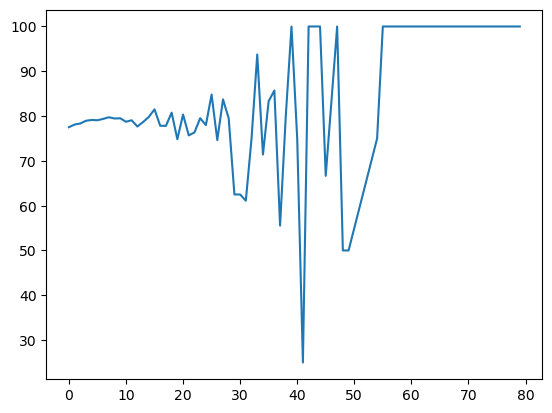

In [22]:
target_column = "total_cu_tl"
#target_column값에 따라 컬럼명 입력하면 해당 필드 값들에서 loan_status가 정상적인 상황(0 : fully paid, in grace,,,) 값 비율 확인할 수 있는 plot입니다.
column_values = filtered_df[target_column].unique()
column_values = column_values[~pd.isna(column_values)]
column_values.sort()
print(column_values)
x = []
y =[]
for value in column_values:
    pos_percent = len(filtered_df[(filtered_df[target_column]==value) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column]==value])
    print(value)
    print(pos_percent)
    x.append(value)
    y.append(pos_percent)

print("na")
print(len(filtered_df[(filtered_df[target_column].isna()) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column].isna()]))
plt.plot(x, y)

In [23]:
def plot_col(filtered_df, target_column):
  """
    target_column의 값 별 비율를 시각화하는 함수

    arguments:
      filtered_df : 데이터프레임
      target_column : filtered_df에서 시각화할 변수
    result:
      barplot 시각화
  """
  column_values = filtered_df[target_column].unique()
  column_values = column_values[~pd.isna(column_values)]
  column_values.sort()
  print("unique column values", column_values)
  print("the number of unique values", len(column_values))

  x = []
  y = []
  for value in column_values:
      pos_percent = len(filtered_df[(filtered_df[target_column]==value) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column]==value])
      print("value : ", value, ", \t pos_percent : ", round(pos_percent,4))
      x.append(value)
      y.append(pos_percent)

  print("num of na", len(filtered_df[(filtered_df[target_column].isna()) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column].isna()]))
  plt.bar(x, y)
  plt.show()